# Predicting NFL Draft Order Based on College Performance and Physical Attributes

### AJ Bensman,  Burke Dugan,  Ethan Pritchard,  Bruce Smith, Jay Stansberry, and Han Sullivan


In [2]:
# Importing packages
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from wordcloud import WordCloud

import pickle
import time
import statsmodels.api as sm
from copy import copy
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
import matplotlib.pyplot as plt

# Preface

We studied data for four positions: Quarterbacks, running backs, wide receivers, and defensive backs. We performed principal components analysis, multiple regression, an SVM, and a multinomial logistic regression for each position.

## Data Pre-Processing
#### Quarterbacks

In [3]:
qb = pd.read_csv('qb_merged_data')

# drop repeat/useless columns
qb = qb.drop(['draft_year', 'position', 'pos_abbr', 'school_name', 'school_abbr', 'link', 'traded', 'trade_note', 'team', 'team_abbr', 'team_logo_espn', 'guid', 'player_image', 'Unnamed: 0', 'alt_player_id', 'school_y', 'Wonderlic', 'Bench Press', '60Yd Shuttle', 'weight', 'height', 'Unnamed: 0.1'], 1)

# replace NA in draft pick data with 0 to indicate undrafted
qb['round'] = qb['round'].fillna(8)
qb['pick'] = qb['pick'].fillna(0)
qb['overall'] = qb['overall'].fillna(0)

# label vector
drafted = []
for i in qb['round']:
    if i == 0.0:
        drafted.append(0)
    else:
        drafted.append(1)

# replace NA with 40th percentile
for i in range(len(qb.columns)):
    if qb.iloc[:,i].dtype != 'O':
        qb.iloc[:,i] = qb.iloc[:,i].fillna(qb.iloc[:,i].quantile(.40))
        
# features should be all quantitative variables,
# should I use pos_rk, ovr_rk, grade
qb_features = qb.drop(['round', 'pick', 'overall', 'Year', 'Name', 'College', 'POS', 'player_id', 'pos_rk', 'ovr_rk', 'grade'], 1)
# Standardize features
qb_features_std = StandardScaler().fit_transform(qb_features)

#### Wide Receivers

In [4]:
wr = pd.read_csv('wr_merged.csv')


wr = wr.drop(['Unnamed: 0', 'draft_year', 'player_id', 'player_name', 'position',
       'pos_abbr', 'school_x', 'school_name', 'school_abbr', 'link', 'traded', 'trade_note', 'team',
        'team_abbr', 'team_logo_espn', 'guid', 'pos_rk', 'Unnamed: 0.1', 'alt_player_id',
       'school_y', 'grade', 'player_image', 'Year', 'College', 'POS', 'Wonderlic', 'height', 'weight'], axis=1)
# 8 indicates undrafted
wr['round'] = wr['round'].fillna(8)

# replace undrafted guys overall pick with realistic number
for i in range(wr.shape[0]):
    if wr.loc[i, 'round'] == 8:
        if wr.loc[i, 'ovr_rk'] <= 262:
            wr.loc[i,'overall'] = 263
        else:
            wr.loc[i,'overall'] = wr.loc[i,'ovr_rk']
            
wr = wr.drop('ovr_rk', axis = 1)
# get class labels
labels = wr['round']

# fill nan values
for c in wr.columns:
    filler = wr[c].quantile(.40)
    wr[c] = wr[c].fillna(filler)
    
wr.head()

,pick,overall,round,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),40 Yard,Bench Press,Vert Leap (in),...,Highest Receiving Touchdowns,Lowest Receiving Touchdowns,Total Yards Per Reception,Mean Yards Per Reception,Highest Yards Per Reception,Lowest Yards Per Reception,Total Long Reception,Mean Long Reception,Highest Long Reception,Lowest Long Reception
0,31.0,206.0,6.0,74.75,212.0,10.50,32.13,4.57,18.0,35.0,...,14.0,5.0,34.0,17.000000,19.6,14.4,113.0,56.500000,69.0,44.0
1,19.6,263.0,8.0,71.50,198.0,9.38,31.63,4.58,12.0,32.5,...,9.0,7.0,26.0,13.000000,14.2,11.8,130.0,65.000000,81.0,49.0
2,19.6,263.0,8.0,72.38,201.0,9.75,32.00,4.57,8.0,33.5,...,16.0,7.0,33.2,16.600000,18.2,15.0,176.0,88.000000,94.0,82.0
3,8.0,40.0,2.0,71.00,196.0,9.50,31.25,4.31,18.0,37.0,...,7.0,0.0,33.4,11.133333,13.1,8.6,149.0,49.666667,79.0,30.0
4,30.0,62.0,2.0,73.25,215.0,10.50,32.88,4.54,15.0,32.5,...,10.0,5.0,42.8,14.266667,16.3,13.1,195.0,65.000000,75.0,53.0


The cell above removed all the columns that we deemed to not be useful to our analysis or duplicates. We also replaced nan entries with appropriate values. For example, we replaced the nan values for round (players who didn't get drafted) with the number 8 since there are 7 rounds in the draft. Undrafted players 'pick' value was repalced with the lesser of 263 and their ESPN prospect rank. 263 was chosen because there are typically 262 picks in the NFL draft

In [5]:
# Here we created the alternate labels for the classifier models, as well as standardizing the features

wr_features = wr.drop(['pick', 'overall', 'round'], 1)
wr_labels = copy(wr['round'])
wr_labels_alt = wr_labels
wr_labels_alt[wr_labels_alt == 1] = 'early'
wr_labels_alt[wr_labels_alt == 2] = 'early'
wr_labels_alt[wr_labels_alt == 3] = 'middle'
wr_labels_alt[wr_labels_alt == 4] = 'middle'
wr_labels_alt[wr_labels_alt == 5] = 'middle'
wr_labels_alt[wr_labels_alt == 6] = 'late'
wr_labels_alt[wr_labels_alt == 7] = 'late'
wr_labels_alt[wr_labels_alt == 8] = 'undrafted'

wr_features_std = StandardScaler().fit_transform(wr_features)
wr_labels_alt

0           late
1      undrafted
2      undrafted
3          early
4          early
         ...    
140    undrafted
141    undrafted
142    undrafted
143    undrafted
144    undrafted
Name: round, Length: 145, dtype: object

#### Runningbacks

In [6]:
#importing and cleaning the data
rb = pd.read_csv('rb_merged.csv')
rb = rb.drop(82,0) #removed a WR that was still in RB data 

#drop unused columns
rb = rb.drop(['Unnamed: 0', 'player_id', 'position',
       'pos_abbr', 'school_x', 'school_name', 'school_abbr', 'link',
         'traded', 'trade_note', 'team', 'team_abbr','school_y',
       'team_logo_espn', 'guid', 'weight', 'height', 'pos_rk',
       'grade', 'player_image', 'Year', 'College', 'POS', 'Wonderlic',
    'Unnamed: 0.1', 'alt_player_id'],1)

rb = rb.reset_index()  #had to reset indexes because the WR drop above messed up the indexing.
rb = rb.drop(columns='index')

rb['round'] = rb['round'].fillna(8)  #sets undrafted round values
for i in range(rb.shape[0]):        #this loop finds the undrafted round values and replaces the overall draft position with 
    if rb.loc[i, 'round'] == 8.0:
        if rb.loc[i, 'ovr_rk'] <= 262:
            rb.loc[i,'overall'] = 263
        else:
            rb.loc[i,'overall'] = rb.loc[i,'ovr_rk']
            
rb = rb.drop('ovr_rk', axis = 1)

# get class labels
rb_labels = rb['overall']


rb.loc[85,'overall']  = 263.0 #manually changed one undrafted player that did not get into the loop

rb_features = rb.iloc[:,5:] #features of each player
rb_draft_info = rb.iloc[:,2:5] #draft info of each player

for col in rb_features.columns:
    fill = rb_features[col].quantile(0.40)  #for the features, fill NaN values with 40th percentile of column
    rb_features[col] = rb_features[col].fillna(fill)

#standardize data
rb_std_features = StandardScaler().fit_transform(rb_features)

#sets alll of the labels that we may use for regression
rb_round_drafted = rb_draft_info['round']
overall_pick = rb_draft_info['overall']
rb_labels = np.array(overall_pick)

#converts our labels and PCA features into DataFrames
rb_features_df = pd.DataFrame(rb_std_features)
rb_labels_df = pd.DataFrame(rb_labels)

rb_features.head()

,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,...,Highest Yards Per Reception,Lowest Yards Per Reception,Total Long Reception,Mean Long Reception,Highest Long Reception,Lowest Long Reception,Total Receiving Touchdowns,Mean Receiving Touchdowns,Highest Receiving Touchdowns,Lowest Receiving Touchdowns
0,70.75,219.0,8.63,31.63,4.54,22.0,34.0,120.0,4.286,7.052,...,8.6,7.1,104.0,52.000000,61.0,43.0,4.0,1.000000,2.0,0.0
1,71.25,202.0,9.00,30.00,4.48,10.0,37.5,121.0,4.220,6.570,...,14.8,8.4,183.0,61.000000,75.0,52.0,20.0,3.333333,5.0,2.0
2,71.13,210.0,9.25,32.38,4.49,22.0,30.5,116.0,4.530,7.270,...,14.8,9.2,125.0,41.666667,59.0,30.0,4.0,0.666667,1.0,0.0
3,72.25,233.0,10.13,31.38,4.49,18.0,32.0,118.0,4.280,7.300,...,12.8,7.0,50.0,16.666667,22.0,7.0,0.0,0.000000,0.0,0.0
4,70.75,210.0,9.38,30.75,4.41,14.0,35.0,125.0,4.190,7.190,...,11.9,7.6,72.0,36.000000,56.0,16.0,0.0,0.000000,0.0,0.0


The above cell sets the undrafted round number to '8'. Seeing as there is only 7 rounds to the NFL draft, we set this value to improve our regression as a larger round value theoretically means a player has worse stats. We then filled in the 'overall' pick label for any undrafter players. The values we filled here depended on the overall ranking of the player, as seen in the above 'for' loop.

#### Defensive Backs

In [7]:
db = pd.read_csv('db_merged.csv')

# drop repeat/useless columns
db = db.drop(['draft_year', 'position', 'pos_abbr', 'school_name', 'school_abbr', 'link', 'traded', 'trade_note', 'team', 'team_abbr', 'team_logo_espn', 'guid', 'player_image', 'Unnamed: 0', 'alt_player_id','school_x', 'school_y', 'Wonderlic', 'Bench Press', 'weight', 'height', 'Unnamed: 0.1'], 1)

# replace NA in draft pick data with 8 to indicate undrafted
db['round'] = db['round'].fillna(8)
# Replace pick with 0 if undrafted
db['pick'] = db['pick'].fillna(0)
for i in range(db.shape[0]):
    if db.loc[i, 'round'] == 8:
        if db.loc[i, 'ovr_rk'] <= 262:
            db.loc[i,'overall'] = 263
        else:
            db.loc[i,'overall'] = db.loc[i,'ovr_rk']

# label vector for drafted/undrafted
drafted = []
for i in db['round']:
    if i == 0.0:
        drafted.append(0)
    else:
        drafted.append(1)

# replace NA with 40th percentile
for i in range(len(db.columns)):
    if db.iloc[:,i].dtype != 'O':
        db.iloc[:,i] = db.iloc[:,i].fillna(db.iloc[:,i].quantile(.40))
        
# features should be all quantitative variables,
# should I use pos_rk, ovr_rk, grade
db_features = db.drop(['round', 'pick', 'overall', 'Year', 'player_name', 'College', 'POS', 'player_id', 'pos_rk', 'ovr_rk', 'grade'], 1)
# Standardize features
db_features_std = StandardScaler().fit_transform(db_features)

The cell above removed all the columns that we deemed to not be useful to our analysis or duplicates. We also replaced nan entries with appropriate values. For example, we replaced the nan values for round (players who didn't get drafted) with the number 8 since there are 7 rounds in the draft. Undrafted players 'pick' value was repalced with the lesser of 263 and their ESPN prospect rank. 263 was chosen because there are typically 262 picks in the NFL draft

## PCA

#### Quarterbacks

In [8]:
n_components = 0
total_variance = 0
while total_variance < 90:
    n_components += 1
    qb_pca = PCA(n_components=n_components)
    qb_pca.fit(qb_features_std)
    total_variance = np.sum(qb_pca.explained_variance_ratio_)*100
print('Number of components:',n_components)
print("Variance accounted for:",total_variance,'%')
qb_pca_features = qb_pca.fit_transform(qb_features_std)

Number of components: 11
Variance accounted for: 91.21073448948816 %


#### Wide Receivers

So 10 components make up 90% of the total explained variance for the quarterbacks

In [9]:
n_components = 0
total_variance = 0
while total_variance < 90:
    n_components += 1
    wr_pca = PCA(n_components=n_components)
    wr_pca.fit(wr_features_std)
    total_variance = np.sum(wr_pca.explained_variance_ratio_)*100
print('Number of components:',n_components)
print("Variance accounted for:",total_variance,'%')
wr_pca_features = wr_pca.fit_transform(wr_features_std)

Number of components: 12
Variance accounted for: 90.36176250784476 %


#### Runningbacks

In [10]:
#PCA, choose num. components that represent at least 90% of variance
var = 0
n_components = 0

while var < 90:
    n_components+=1
    rb_pca = PCA(n_components=n_components)
    rb_pca.fit(rb_std_features)
    var = np.sum(rb_pca.explained_variance_ratio_)*100

print('Number of components:',n_components)
print("Variance accounted for:",var,'%')
rb_pca_features = rb_pca.fit_transform(rb_std_features)   #create the PCA features

Number of components: 15
Variance accounted for: 90.6959734804211 %


#### Defensive Backs

So 12 components make up 90% of the total explained variance for the wide receivers

In [11]:
# find the number of components that explain 90% of the total variance
n_components = 0
total_variance = 0
while total_variance < 90:
    n_components += 1
    db_pca = PCA(n_components=n_components)
    db_pca.fit(db_features_std)
    total_variance = np.sum(db_pca.explained_variance_ratio_)*100
print('Number of components:',n_components)
print("Variance accounted for:",total_variance,'%')
# Transform the features using our 90% variance PCA
db_pca_features = db_pca.fit_transform(db_features_std)

Number of components: 15
Variance accounted for: 90.5605457255275 %


# Analysis

## Quarterbacks


### Multiple Regression QB with overall pick and all features

In [12]:
qb_labels_df = pd.DataFrame(qb['overall']) #Making the labels for each player by overall pick

qb_lm_overall = sm.OLS(qb_labels_df,sm.add_constant(qb_features)).fit()#Multiple regression with player's overall picks and features from data frame
qb_lm_overall.summary()

# This warning is thrown because of the high multicollinearity. We kept this in since we did it for all the other positions


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 25 Apr 2022   Prob (F-statistic):                nan
Time:                        22:20:33   Log-Likelihood:                 887.43
No. Observations:                  38   AIC:                            -1699.
Df Residuals:                       0   BIC:                            -1637.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0368        inf         -0        nan         nan         nan
Height (in)                       -8.0492        inf         -0        nan         nan         nan
Weight (lbs)                       3.7376        inf          0        nan         nan         nan
Hand Size (in)                     0.9045        inf          0        nan         nan         nan
Arm Length (in)                    9.1426        inf          0        nan         nan         nan
40 Yard                           -3.9034        inf         -0        nan         nan         nan
Vert Leap (in)                    -6.0093        inf         -0        nan         nan         nan
Broad Jump (in)                    3.7804        inf          0        nan         nan         nan
Shuttle                            2.3265        inf          0        nan         nan         nan
3Cone                              0.2717        inf          0        nan         nan         nan
Total Completions                  3.2798        inf          0        nan         nan         nan
Mean Completions                  -7.1900        inf         -0        nan         nan         nan
Highest Completions               -1.6455        inf         -0        nan         nan         nan
Lowest Completions               -13.3145        inf         -0        nan         nan         nan
Total Passing Attempts            -2.4153        inf         -0        nan         nan         nan
Mean Passing Attempts              4.8406        inf          0        nan         nan         nan
Highest Passing Attempts           1.6128        inf          0        nan         nan         nan
Lowest Passing Attempts            6.4573        inf          0        nan         nan         nan
Total Completion Percentage       -4.4199        inf         -0        nan         nan         nan
Mean Completion Percentage       -11.1315        inf         -0        nan         nan         nan
Highest Completion Percentage     -5.2202        inf         -0        nan         nan         nan
Lowest Completion Percentage      10.1908        inf          0        nan         nan         nan
Total Passing Yards               -0.0439        inf         -0        nan         nan         nan
Mean Passing Yards                 0.0796        inf          0        nan         nan         nan
Highest Passing Yards              0.1109        inf          0        nan         nan         nan
Lowest Passing Yards               0.3520        inf          0        nan         nan         nan
Total Yards Per Pass Attempt     -14.0448        inf         -0        nan         nan         nan
Mean Yards Per Pass Attempt       -5.3463        inf         -0        nan         nan         nan
Highest Yards 

Results were inconclusive due to strong multicollinearity, lack of overall data on Quarterbacks, and lack of variance among the data

### Multiple Regression QB with overall pick and PCA features

In [13]:
qb_pca_features_df = pd.DataFrame(qb_pca_features) #Saving features from PCA into a dataframe to use in regression

In [14]:
qb_lm_pca_overall = sm.OLS(qb_labels_df,sm.add_constant(qb_pca_features_df)).fit()#Multiple regression with player's overall picks and pca features
qb_lm_pca_overall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     1.421
Date:                Mon, 25 Apr 2022   Prob (F-statistic):              0.222
Time:                        22:20:33   Log-Likelihood:                -210.44
No. Observations:                  38   AIC:                             444.9
Df Residuals:                      26   BIC:                             464.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.6316     12.060      5.193      0.000      37.843      87.421
0             -0.4295      3.072     -0.140      0.890      -6.744       5.885
1             -4.5496      3.646     -1.248      0.223     -12.045       2.946
2             -8.7172      4.318     -2.019      0.054     -17.592       0.158
3             -4.4189      4.879     -0.906      0.373     -14.448       5.610
4              4.8424      5.629      0.860      0.398      -6.729      16.414
5              5.9251      7.124      0.832      0.413      -8.718      20.568
6            -11.3501      7.825     -1.450      0.159     -27.435       4.735
7              1.3478      8.197      0.164      0.871     -15.501      18.196
8             -7.0538     10.767     -0.655      0.518     -29.185      15.077
9              1.4998     11.431      0.131      0.897     -21.997      24.997
10            27.1565     11.962      2.270      0.032       2.569      51.744
==============================================================================
Omnibus:                        2.354   Durbin-Watson:                   2.341
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                1.815
Skew:                           0.535   Prob(JB):                        0.404
Kurtosis:                       2.960   Cond. No.                         3.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An okay r-squared for our full Multiple Regression with the PCA features, but the adjusted r-squared is very poor. The coefficients are not too signifcant as we did not look to make a predicting model for this, but to see what features had small p-values. We considered features 2, 6, and 7 to be the features with significant p-values.

In [15]:
qb_new_features_df = qb_pca_features_df.drop(columns = [0,1,3,4,5,8,9]) #Dropping features with a large p-value

pca_lm_pca_best_qb = sm.OLS(qb_labels_df,sm.add_constant(qb_new_features_df)).fit() #Redoing regression with features that have low p-values
pca_lm_pca_best_qb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     3.096
Date:                Mon, 25 Apr 2022   Prob (F-statistic):             0.0287
Time:                        22:20:33   Log-Likelihood:                -213.33
No. Observations:                  38   AIC:                             436.7
Df Residuals:                      33   BIC:                             444.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.6316     11.551      5.422      0.000      39.131      86.132
2             -8.7172      4.136     -2.108      0.043     -17.131      -0.303
6            -11.3501      7.495     -1.514      0.139     -26.599       3.899
7              1.3478      7.851      0.172      0.865     -14.625      17.321
10            27.1565     11.457      2.370      0.024       3.847      50.466
==============================================================================
Omnibus:                        3.179   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.941
Skew:                           0.630   Prob(JB):                        0.230
Kurtosis:                       2.478   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we attempt to extract the most important features from the coefficients

In [16]:
orig_coeff = np.matmul(qb_pca.components_.transpose(), np.reshape(np.array(qb_lm_pca_overall.params[1:]), (np.array(qb_lm_pca_overall.params[1:]).shape[0], 1)))
# normalize to see what is important
norm_coeff = orig_coeff * np.reshape(np.array(qb_features.std()), (np.array(qb_features.std()).shape[0],1))
# I would not read too much into the exact coefficients or their sign, but largest magnitudes are most important
# Should be in the same order as features were
coeff = []
for i in range(len(norm_coeff)):
    coeff.append((norm_coeff[i], qb_features.columns[i]))
importance = sorted(coeff, key = lambda x: abs(x[0]), reverse = True)
importance

[(array([-6182.12952101]), 'Lowest Passing Yards'),
 (array([-1658.37778868]), 'Mean Passing Yards'),
 (array([-1482.50067291]), 'Total Rushing Yards'),
 (array([-1337.44990627]), 'Highest Rushing Yards'),
 (array([-1013.43057056]), 'Highest Passing Yards'),
 (array([758.49626979]), 'Total Passing Yards'),
 (array([-673.84690432]), 'Lowest Passing Attempts'),
 (array([588.28554631]), 'Lowest Rushing Yards'),
 (array([-429.9602416]), 'Lowest Completions'),
 (array([-330.06430564]), 'Total Rushing Attempts'),
 (array([291.33664756]), 'Total Passing Touchdowns'),
 (array([-261.37484547]), 'Mean Passing Attempts'),
 (array([-244.52853154]), 'Highest Passing Attempts'),
 (array([-209.29317371]), 'Mean Completions'),
 (array([-205.27776502]), 'Total Completions'),
 (array([-168.49786133]), 'Total Passing Attempts'),
 (array([-159.77601147]), 'Highest Completions'),
 (array([144.95134517]), 'Total Longest Pass'),
 (array([-123.1457423]), 'Highest Rushing Attempts'),
 (array([-119.43412207]), 

(-0.5, 999.5, 499.5, -0.5)

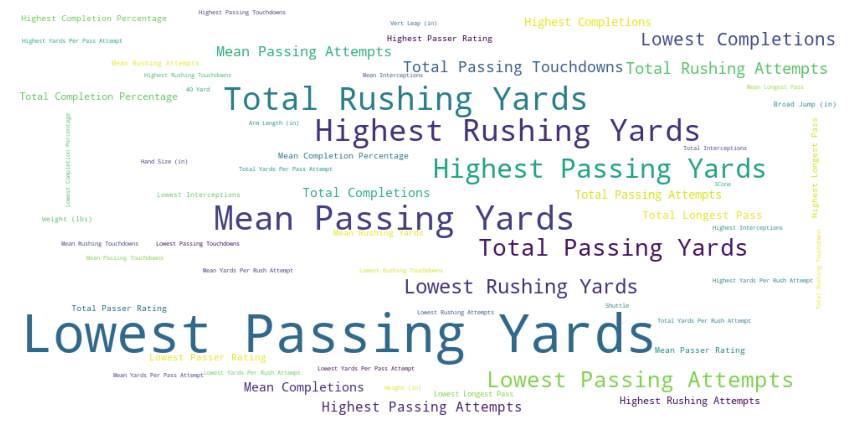

In [17]:
counter = dict()
for att in importance:
    counter[att[1]] = max(10, abs(int(att[0][0]))//2) # make the less used features easier to read
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

Not surprisingly, passing yards were by far the most significant for quarterbacks, followed by running yards. This makes sense, as quarterbacks entire job is pretty much throwing the ball.

# SVM for QBs

In [18]:
qb_labels = copy(qb['round'])
# Here we make alternate labels for classifying the draftees
qb_labels_alt = qb_labels
qb_labels_alt[qb_labels_alt == 1] = 'early'
qb_labels_alt[qb_labels_alt == 2] = 'early'
qb_labels_alt[qb_labels_alt == 3] = 'middle'
qb_labels_alt[qb_labels_alt == 4] = 'middle'
qb_labels_alt[qb_labels_alt == 5] = 'middle'
qb_labels_alt[qb_labels_alt == 6] = 'late'
qb_labels_alt[qb_labels_alt == 7] = 'late'
qb_labels_alt[qb_labels_alt == 8] = 'undrafted'


In [19]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(qb_pca_features, qb_labels_alt, random_state=4)

In [20]:
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
              'gamma': [0.0005, 0.001, 0.005, 0.01]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
clf = clf.fit(train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

end = time.time()
print("Runtime",end - start)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10.0, class_weight='balanced', gamma=0.01)
Runtime 2.532248020172119


In [21]:
pred_labels = clf.predict(test_vectors)

print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels, labels=qb_labels_alt.unique()))

num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1

print("accuracy:", num_correct/len(pred_labels))


              precision    recall  f1-score   support

       early       0.43      0.75      0.55         4
        late       0.00      0.00      0.00         1
      middle       0.00      0.00      0.00         2
   undrafted       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.11      0.19      0.14        10
weighted avg       0.17      0.30      0.22        10

[[0 0 1 1]
 [1 0 2 0]
 [1 0 3 0]
 [0 0 1 0]]
accuracy: 0.3


We didn't have as much data points for our quarterbacks as the other positions, so our models aren't very accurate.

Text(69.0, 0.5, 'Actual Round')

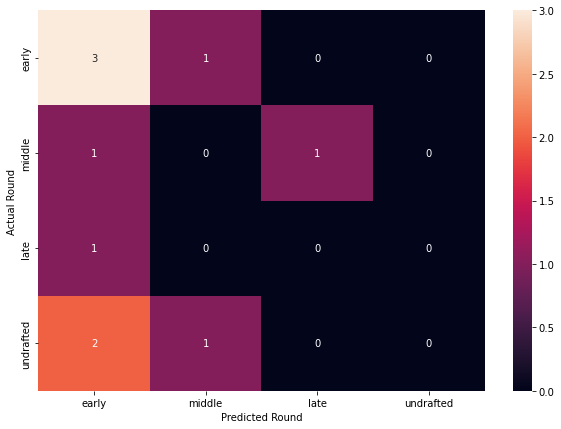

In [22]:

# Making an array from a confusion matrix for plotting in seaborn
cm_arr = confusion_matrix(test_labels, pred_labels,labels=['early', 'middle', 'late', 'undrafted'])

cm_df = pd.DataFrame(cm_arr, index = ['early', 'middle', 'late', 'undrafted'],
                  columns = ['early', 'middle', 'late', 'undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, annot=True)
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

              precision    recall  f1-score   support

       early       0.57      1.00      0.73         4
        late       0.00      0.00      0.00         1
      middle       0.00      0.00      0.00         2
   undrafted       0.00      0.00      0.00         3

    accuracy                           0.40        10
   macro avg       0.14      0.25      0.18        10
weighted avg       0.23      0.40      0.29        10

accuracy: 0.4 was best at c =  0.1


Text(69.0, 0.5, 'Actual Round')

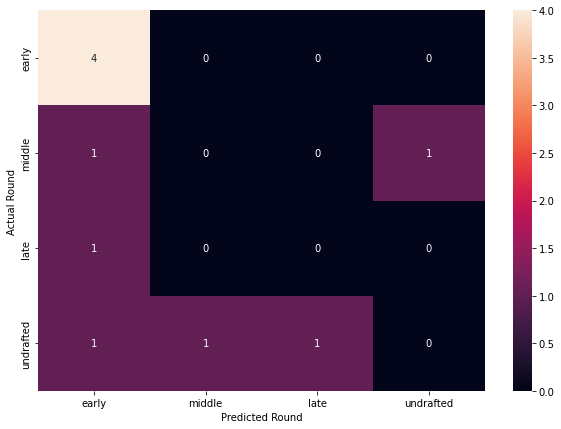

In [23]:
cs = [.1*i for i in range(1, 11)]
multinomialModel = None
most_correct = 0
best_c = 0
for c in cs:
    multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=c)
    multinomialModel.fit(train_vectors, train_labels)
    pred_labels = multinomialModel.predict(test_vectors)

    num_correct = 0
    for i in range(len(pred_labels)):
        if pred_labels[i] == list(test_labels)[i]:
            num_correct += 1
            
    if num_correct > most_correct:
        best_c = c
        most_correct = num_correct
        
        
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=best_c)

multinomialModel.fit(train_vectors, train_labels)

pred_labels = multinomialModel.predict(test_vectors)

print(classification_report(test_labels, pred_labels))


num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1

print("accuracy:", num_correct/len(pred_labels), "was best at c = ", best_c)

import seaborn as sn
import matplotlib.pyplot as plt
arr = confusion_matrix(test_labels, pred_labels, labels=['early', 'middle', 'late', 'undrafted'])

df_cm = pd.DataFrame(arr, index = ['early', 'middle', 'late', 'undrafted'],
                  columns = ['early', 'middle', 'late', 'undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

Our multinomial model proved to be slightly more accurate than our SVM, but it still wasn't very good.

## Wide Receivers

### SVM

In [24]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(wr_pca_features, wr_labels_alt, random_state=7)

In [25]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1, 5, 10.0, 50.0, 75],
              'gamma': [0.0005, 0.001, 0.005, 0.01],
             'kernel': ['linear', 'rbf']}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, n_jobs=-1)
clf = clf.fit(train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

pred_labels = clf.predict(test_vectors)

print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels, labels=test_labels.unique()))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5, class_weight='balanced', gamma=0.001)
              precision    recall  f1-score   support

       early       0.44      0.88      0.58         8
        late       0.50      0.22      0.31         9
      middle       0.00      0.00      0.00         5
   undrafted       0.69      0.60      0.64        15

    accuracy                           0.49        37
   macro avg       0.41      0.42      0.38        37
weighted avg       0.50      0.49      0.46        37

[[9 2 2 2]
 [1 0 4 0]
 [0 1 7 0]
 [3 1 3 2]]


Text(69.0, 0.5, 'Actual Round')

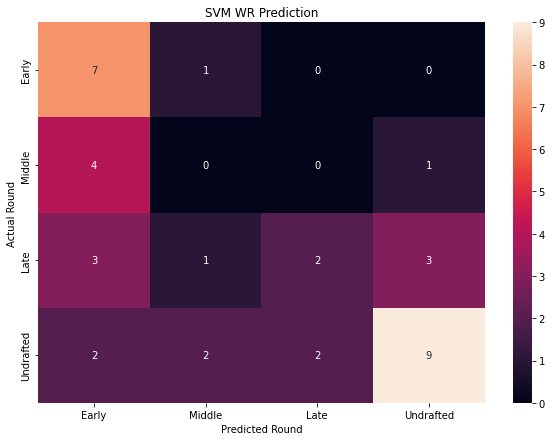

In [26]:

arr = confusion_matrix(test_labels, pred_labels, labels=['early', 'middle', 'late', 'undrafted'])

df_cm = pd.DataFrame(arr, index = ['Early', 'Middle', 'Late', 'Undrafted'],
                  columns = ['Early', 'Middle', 'Late', 'Undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.title('SVM WR Prediction')
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

The above support vector machine uses the features to predict whether the players will be an early, late, middle round, or undrafted player. The model was not particarly accurate, having a recall of only .49. However, it did a decent job of identifying players taken in the early rounds or that went undrafted. The best fit parameters it found were c=5 and gamma=.001

# Multinomial Regression

              precision    recall  f1-score   support

       early       0.50      0.75      0.60         8
        late       0.25      0.11      0.15         9
      middle       0.00      0.00      0.00         5
   undrafted       0.71      0.80      0.75        15

    accuracy                           0.51        37
   macro avg       0.36      0.42      0.38        37
weighted avg       0.46      0.51      0.47        37

accuracy: 0.5135135135135135 was best at c =  0.2


Text(69.0, 0.5, 'Actual Round')

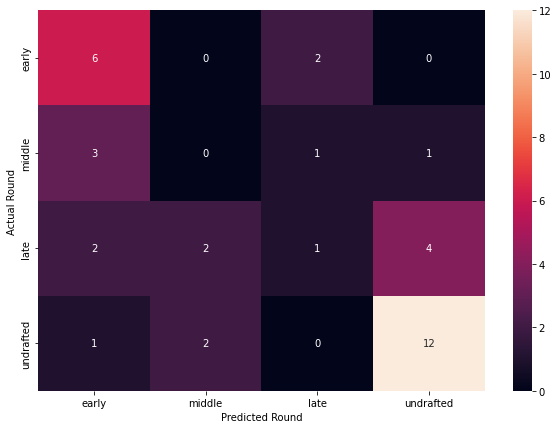

In [27]:
cs = [.1*i for i in range(1, 11)]
multinomialModel = None
most_correct = 0
best_c = 0
for c in cs: # loop through multiple C's to try them all
    multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100000, C=c)
    multinomialModel.fit(train_vectors, train_labels)
    pred_labels = multinomialModel.predict(test_vectors)

    num_correct = 0
    for i in range(len(pred_labels)):
        if pred_labels[i] == list(test_labels)[i]:
            num_correct += 1
            
    if num_correct > most_correct:
        best_c = c
        most_correct = num_correct
        
        
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, C=best_c)

multinomialModel.fit(train_vectors, train_labels)

pred_labels = multinomialModel.predict(test_vectors)

print(classification_report(test_labels, pred_labels))


num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1

print("accuracy:", num_correct/len(pred_labels), "was best at c = ", best_c)

import seaborn as sn
import matplotlib.pyplot as plt
arr = confusion_matrix(test_labels, pred_labels, labels=['early', 'middle', 'late', 'undrafted'])

df_cm = pd.DataFrame(arr, index = ['early', 'middle', 'late', 'undrafted'],
                  columns = ['early', 'middle', 'late', 'undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

The cells above perform multinomial logistic regression. Multinomial logistic regression allows logistic regression to expand from binary classification to allow more class labels. The multinomial model performed slightly better than the SVM with a recall or .51. It, too, was best at identifying early round picks and undrafted players.

# Multiple Regression

## Regressing based on overall pick with all features

In [28]:
# Regular multiple regression using overall
x = sm.add_constant(wr_features)
wr_lm_overall = sm.OLS(wr['overall'], x).fit()
wr_lm_overall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4.438
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           2.87e-09
Time:                        22:20:38   Log-Likelihood:                -810.84
No. Observations:                 145   AIC:                             1686.
Df Residuals:                     113   BIC:                             1781.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1626.7028   1317.302     -1.235      0.219   -4236.516     983.111
Height (in)                      9.2343      5.921      1.560      0.122      -2.496      20.964
Weight (lbs)                    -1.7346      0.766     -2.263      0.026      -3.253      -0.216
Hand Size (in)                  -5.7501     17.831     -0.322      0.748     -41.077      29.577
Arm Length (in)                -10.3207      8.601     -1.200      0.233     -27.361       6.720
40 Yard                        424.5781     84.086      5.049      0.000     257.989     591.167
Bench Press                     -1.7567      2.183     -0.805      0.423      -6.082       2.569
Vert Leap (in)                   1.9559      3.133      0.624      0.534      -4.252       8.164
Broad Jump (in)                  0.6430      0.683      0.941      0.348      -0.710       1.996
Shuttle                        -24.8681     56.350     -0.441      0.660    -136.508      86.772
3Cone                           98.7155     39.490      2.500      0.014      20.478     176.953
60Yd Shuttle                   -45.2518    105.673     -0.428      0.669    -254.609     164.106
Total Receptions                -0.1776      1.159     -0.153      0.878      -2.473       2.118
Mean Receptions                 -1.3905      4.630     -0.300      0.764     -10.562       7.782
Highest Receptions               0.1928      1.525      0.126      0.900      -2.828       3.213
Lowest Receptions               -0.7924      2.093     -0.379      0.706      -4.939       3.355
Total Receiving Yards           -0.0427      0.103     -0.416      0.678      -0.246       0.161
Mean Receiving Yards             0.2880      0.367      0.786      0.434      -0.438       1.014
Highest Receiving Yards         -0.0589      0.113     -0.520      0.604      -0.283       0.165
Lowest Receiving Yards           0.0400      0.150      0.267      0.790      -0.257       0.337
Total Receiving Touchdowns       1.2795      1.622      0.789      0.432      -1.934       4.493
Mean Receiving Touchdowns       -0.3253     11.153     -0.029      0.977     -22.421      21.770
Highest Receiving Touchdowns    -8.5665      4.766     -1.797      0.075     -18.009       0.876
Lowest Receiving Touchdowns      4.0277      7.033      0.573      0.568      -9.906      17.961
Total Yards Per Reception       -2.4824      3.416     -0.727      0.469      -9.249       4.285
Mean Yards Per Reception        -8.4221     20.509     -0.411      0.682     -49.055      32.210
Highest Yards Per Reception     11.3825      6.347      1.793      0.076      -1.192      23.956
Lowest Yards Per Reception      -4.3361      6.255     -0.693      0.490     -16.729       8.057
Total Long Reception             0.9765      1.062      0.920      0.360    

The model is ok with a R-squared of 54.9%. Most of the coefficients are insignificant, but due to the amount of variables and strong multicollinearity, interpreting the coefficients would not be advised, although we could attempt to use this model for prediction purposes.

## Regressing based on overall with just PCA features

In [29]:
# regression with pca overall
x = sm.add_constant(wr_pca_features)
wr_pca_lm = sm.OLS(wr['overall'], x).fit()
wr_pca_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     8.053
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           3.50e-11
Time:                        22:20:38   Log-Likelihood:                -828.75
No. Observations:                 145   AIC:                             1683.
Df Residuals:                     132   BIC:                             1722.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.2483      6.393     29.290      0.000     174.603     199.894
x1           -10.8728      2.091     -5.200      0.000     -15.009      -6.737
x2            14.3994      3.320      4.337      0.000       7.831      20.967
x3             1.7954      3.391      0.530      0.597      -4.912       8.502
x4            -4.0702      3.855     -1.056      0.293     -11.696       3.555
x5            20.1780      4.320      4.671      0.000      11.632      28.724
x6            -3.8864      5.559     -0.699      0.486     -14.883       7.110
x7            -9.7817      6.054     -1.616      0.109     -21.756       2.193
x8            -9.1439      6.228     -1.468      0.144     -21.464       3.177
x9            -8.5907      6.692     -1.284      0.201     -21.827       4.646
x10          -17.4852      7.100     -2.463      0.015     -31.530      -3.441
x11          -28.9473      7.973     -3.631      0.000     -44.718     -13.176
x12           -9.8253      8.225     -1.195      0.234     -26.095       6.444
==============================================================================
Omnibus:                        0.446   Durbin-Watson:                   0.951
Prob(Omnibus):                  0.800   Jarque-Bera (JB):                0.178
Skew:                           0.052   Prob(JB):                        0.915
Kurtosis:                       3.137   Cond. No.                         3.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The PCA regression should remove much of the multicollinearity that plagued the previous model, although the model itself has a samller R squared and probably shouldn't be used for prediction purposes. This model also does not give us any information on what features are important.

## Get importance of features out of the PCA

In [30]:
# this should hopefully give the coefficients from the regression in terms of the original variables
orig_coeff = np.matmul(wr_pca.components_.transpose(), np.reshape(np.array(wr_pca_lm.params[1:]), (np.array(wr_pca_lm.params[1:]).shape[0], 1)))
# normalize to see what is important
norm_coeff = orig_coeff * np.reshape(np.array(wr_features.std()), (np.array(wr_features.std()).shape[0],1))
# I would not read too much into the exact coefficients or their sign, but largest magnitudes are most important
coeff = []
for i in range(len(norm_coeff)):
    coeff.append((norm_coeff[i], wr_features.columns[i]))
importance = sorted(coeff, key = lambda x: abs(x[0]), reverse=True)
importance

[(array([-1790.55495004]), 'Total Receiving Yards'),
 (array([750.42722472]), 'Lowest Receiving Yards'),
 (array([-541.94861836]), 'Highest Receiving Yards'),
 (array([-413.41315838]), 'Mean Receiving Yards'),
 (array([-338.87382712]), 'Total Long Reception'),
 (array([-206.02551371]), 'Highest Long Reception'),
 (array([-155.72775841]), 'Mean Long Reception'),
 (array([155.079683]), 'Broad Jump\xa0(in)'),
 (array([-140.98923775]), 'Weight\xa0(lbs)'),
 (array([-106.15610158]), 'Lowest Long Reception'),
 (array([-92.60982942]), 'Total Receiving Touchdowns'),
 (array([60.807251]), 'Total Yards Per Reception'),
 (array([55.12278168]), 'Lowest Receptions'),
 (array([-50.06947741]), 'Vert Leap\xa0(in)'),
 (array([-33.46051557]), 'Total Receptions'),
 (array([-25.61871439]), 'Bench Press'),
 (array([21.83968702]), 'Highest Yards Per Reception'),
 (array([-20.03165725]), 'Highest Receiving Touchdowns'),
 (array([-14.02210318]), 'Mean Receiving Touchdowns'),
 (array([10.47692658]), 'Lowest Rec

We can transform the coefficients from the PCA regression back to the original coefficients so that we can gain some meaning. Multiplying by the standard deviation, we can see the most important features. The most important appear to be all the information on season recieving yards, longest reception, broad jump and weight. 

(-0.5, 999.5, 499.5, -0.5)

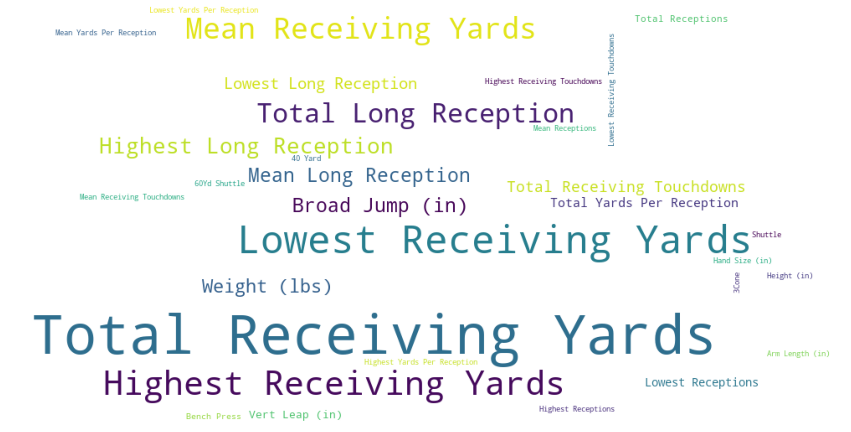

In [31]:


counter = dict()
for att in importance:
    counter[att[1]] = max(10, abs(int(att[0][0]))//2) # make the less used features easier to read
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")


# Runningbacks

## Multiple Regression

In [32]:


#PCA multiple regression
model = sm.OLS(rb_labels_df,sm.add_constant(rb_pca_features))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     4.644
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           4.67e-06
Time:                        22:20:39   Log-Likelihood:                -483.42
No. Observations:                  86   AIC:                             998.8
Df Residuals:                      70   BIC:                             1038.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.3605      7.988     20.575      0.000     148.428     180.293
x1           -13.8172      2.148     -6.433      0.000     -18.101      -9.534
x2             1.4996      2.954      0.508      0.613      -4.393       7.392
x3             6.0186      3.894      1.545      0.127      -1.748      13.786
x4             6.8739      4.246      1.619      0.110      -1.594      15.342
x5             9.3979      4.604      2.041      0.045       0.216      18.580
x6             2.1033      4.899      0.429      0.669      -7.668      11.875
x7             1.2429      5.302      0.234      0.815      -9.332      11.818
x8           -10.1395      5.892     -1.721      0.090     -21.890       1.611
x9             5.8586      6.189      0.947      0.347      -6.484      18.202
x10          -10.7730      6.727     -1.601      0.114     -24.190       2.644
x11           -4.2551      7.628     -0.558      0.579     -19.468      10.958
x12            4.9280      7.878      0.626      0.534     -10.783      20.639
x13          -23.0969      8.327     -2.774      0.007     -39.704      -6.490
x14           -7.5565      9.248     -0.817      0.417     -26.001      10.888
x15           16.6294      9.432      1.763      0.082      -2.183      35.442
==============================================================================
Omnibus:                        0.881   Durbin-Watson:                   1.179
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.462
Skew:                           0.152   Prob(JB):                        0.794
Kurtosis:                       3.192   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above cell contains the results of a multiple regression using all 15 of the PCA components. As you can see, the adjusted R-squared value is fairly low indicating the fit is not great. We observed some very high P-values so we decided to remove those components and create a reduced model (below) in an attempt to improve the fit. 

In [33]:
#PCA multiple regression with reduced number of features
reduced_train = pd.DataFrame(rb_pca_features).drop(columns=[1,5,6,10,11])  #creating reduced model based on p-value of previous model
model = sm.OLS(rb_labels_df,sm.add_constant(reduced_train))
red_fit = model.fit()
red_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     7.211
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.32e-08
Time:                        22:20:39   Log-Likelihood:                -484.15
No. Observations:                  86   AIC:                             990.3
Df Residuals:                      75   BIC:                             1017.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.3605      7.783     21.117      0.000     148.855     179.865
0            -13.8172      2.093     -6.603      0.000     -17.986      -9.649
2              6.0186      3.794      1.586      0.117      -1.540      13.577
3              6.8739      4.137      1.662      0.101      -1.367      15.115
4              9.3979      4.486      2.095      0.040       0.462      18.334
7            -10.1395      5.740     -1.766      0.081     -21.575       1.296
8              5.8586      6.030      0.972      0.334      -6.154      17.871
9            -10.7730      6.555     -1.644      0.104     -23.831       2.285
12           -23.0969      8.113     -2.847      0.006     -39.259      -6.935
13            -7.5565      9.011     -0.839      0.404     -25.507      10.394
14            16.6294      9.190      1.809      0.074      -1.679      34.937
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   1.128
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.223
Skew:                           0.106   Prob(JB):                        0.894
Kurtosis:                       3.132   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above is the multiple regression for a reduced amount of PCA components. We removed components with relatively high P-values. The adjusted R-squared is slightly better but is still low indicating that the PCA components are not highly correlated.

In [34]:
#Regression with all original features
all_feat = rb_features

model = sm.OLS(rb_labels_df,sm.add_constant(all_feat))
all_fit = model.fit()
all_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     2.389
Date:                Mon, 25 Apr 2022   Prob (F-statistic):            0.00427
Time:                        22:20:39   Log-Likelihood:                -447.65
No. Observations:                  86   AIC:                             999.3
Df Residuals:                      34   BIC:                             1127.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1524.3078   1666.820     -0.915      0.367   -4911.693    1863.078
Height (in)                       13.4161     10.230      1.311      0.198      -7.373      34.206
Weight (lbs)                      -4.0052      1.631     -2.456      0.019      -7.320      -0.691
Hand Size (in)                   -20.2449     31.374     -0.645      0.523     -84.004      43.514
Arm Length (in)                   18.7857     14.333      1.311      0.199     -10.343      47.915
40 Yard                          294.8759    159.229      1.852      0.073     -28.717     618.469
Bench Press                        3.1636      3.018      1.048      0.302      -2.969       9.296
Vert Leap (in)                     2.4279      4.750      0.511      0.613      -7.225      12.081
Broad Jump (in)                   -0.3438      2.601     -0.132      0.896      -5.629       4.942
Shuttle                          -67.9405    129.686     -0.524      0.604    -331.494     195.613
3Cone                             61.8483     94.048      0.658      0.515    -129.279     252.976
60Yd Shuttle                     -27.7160    100.930     -0.275      0.785    -232.831     177.399
Total Rushing Attempts             1.2870      1.201      1.071      0.292      -1.155       3.729
Mean Rushing Attempts             -4.3320      3.489     -1.242      0.223     -11.423       2.759
Highest Rushing Attempts           0.2306      0.665      0.347      0.731      -1.121       1.582
Lowest Rushing Attempts            0.2682      0.888      0.302      0.764      -1.537       2.073
Total Rushing Yards               -0.1266      0.257     -0.493      0.625      -0.648       0.395
Mean Rushing Yards                 0.4219      0.776      0.544      0.590      -1.156       1.999
Highest Rushing Yards             -0.0206      0.114     -0.181      0.858      -0.252       0.211
Lowest Rushing Yards              -0.2195      0.167     -1.312      0.198      -0.560       0.121
Total Yards Per Rush Attempt      18.1139     13.161      1.376      0.178      -8.632      44.859
Mean Yards Per Rush Attempt     -118.2526     56.958     -2.076      0.046    -234.004      -2.501
Highest Yards Per Rush Attempt    34.1911     21.887      1.562      0.128     -10.288      78.670
Lowest Yards Per Rush Attempt     11.0153     19.035      0.579      0.567     -27.668      49.699
Total Rushing Touchdowns           1.0161      3.157      0.322      0.750      -5.400       7.432
Mean Rushing Touchdowns           -2.1163     21.221     -0.100      0.921     -45.243      41.011
Highest Rushing Touchdowns        -8.9302      5.302     -1.684      0.101     -19.706       1.846
Lowest Rushing Touchdowns         16.5048      9.525      1.733      0.092      -2.852      35.861
Total Long Rus

Next, we decided to perform a multiple regression using all of the original features. Surprisingly, this provided the highest adjusted R-squared value for our running back regression. There is a note about collinearity at the bottom suggesting multiple features are linearly correlated leading to the possibility of a reduced fit being better. Overall, this model provided the best multiple regression fit for running backs.

# Features of Most Importance

In [35]:
#using matrix manipulations to find out which of the original features are most important according to the PCA
orig_coeff = np.matmul(rb_pca.components_.transpose(), np.reshape(np.array(fit.params[1:]), (np.array(fit.params[1:]).shape[0], 1)))
norm_coeff = orig_coeff * np.reshape(np.array(rb_features.std()), (np.array(rb_features.std()).shape[0],1))

#create a list with the highest coefficients and their corresponding feature
coeff = []
for i in range(len(norm_coeff)):
    coeff.append((norm_coeff[i], rb_features.columns[i]))
print("Most important features (high magnitudes = more important):")
importance = sorted(coeff, key = lambda x: abs(x[0]), reverse = True) #sort by highest magnitudes
importance

Most important features (high magnitudes = more important):


[(array([-1723.18105528]), 'Total Rushing Yards'),
 (array([-1666.62178146]), 'Highest Rushing Yards'),
 (array([-1155.50494707]), 'Total Receiving Yards'),
 (array([-1123.40880458]), 'Highest Receiving Yards'),
 (array([-1118.24055973]), 'Mean Rushing Yards'),
 (array([673.5151584]), 'Lowest Rushing Yards'),
 (array([-353.21577464]), 'Mean Receiving Yards'),
 (array([203.02804104]), 'Total Long Reception'),
 (array([-180.99807815]), 'Total Rushing Touchdowns'),
 (array([180.42122812]), 'Lowest Rushing Attempts'),
 (array([120.50967031]), 'Highest Long Reception'),
 (array([-116.85711676]), 'Highest Rushing Attempts'),
 (array([104.64908424]), 'Lowest Receiving Yards'),
 (array([-84.90356044]), 'Mean Rushing Attempts'),
 (array([82.17659517]), 'Total Rushing Attempts'),
 (array([71.10920014]), 'Total Long Rushing'),
 (array([-69.27611687]), 'Highest Long Rushing'),
 (array([-65.79115925]), 'Highest Rushing Touchdowns'),
 (array([-50.40993354]), 'Highest Receptions'),
 (array([40.945277

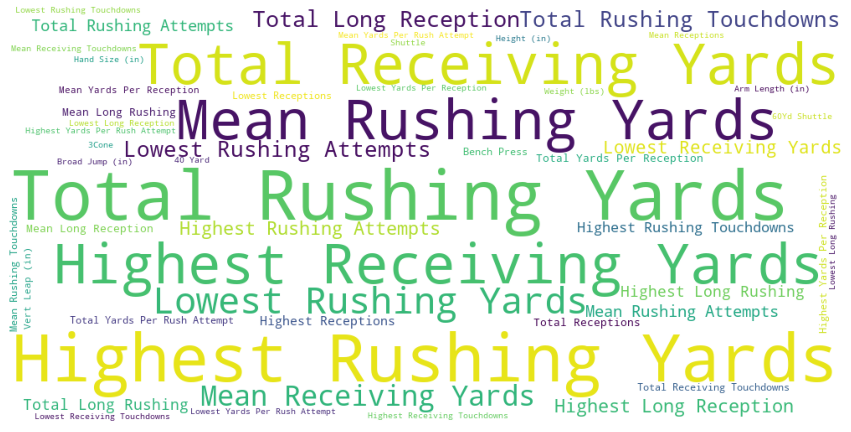

In [36]:
counter = dict()
for att in importance:
    counter[att[1]] = max(10, abs(int(att[0][0]))//2) # make the less used features easier to read
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The above two cells contain code to find the most important features according the PCA. In the first cell, we performed mathematical manipulations to the PCA components in order to find what features had the greatest importance for the PCA. In the cell above, we implemented a word cloud to visualize the most important features.

# SVM Preprocessing

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
#create alternate labels to classify the round drafted as early, middle, or late
rb_labels_alt = rb['round']
rb_labels_alt[rb_labels_alt == 1.0] = 'early'
rb_labels_alt[rb_labels_alt == 2.0] = 'early'
rb_labels_alt[rb_labels_alt== 3.0] = 'middle'
rb_labels_alt[rb_labels_alt== 4.0] = 'middle'
rb_labels_alt[rb_labels_alt== 5.0] = 'middle'
rb_labels_alt[rb_labels_alt== 6.0] = 'late'
rb_labels_alt[rb_labels_alt== 7.0] = 'late'
rb_labels_alt[rb_labels_alt== 8.0] = 'undrafted'

In the above cell, we created new labels to describe a players round draft position as 'early', 'middle', or 'late' to reduce the number of classes that we use for the SVM.

In [39]:
#create testing and training data sets
train_vectors, test_vectors, train_labels, test_labels = train_test_split(rb_pca_features, rb_labels_alt, train_size = 0.75, random_state=4)

# Training the SVM Model

In [40]:
# Train a SVM classification model

start = time.time()

print("Fitting the classifier to the training set")
# a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
param_grid = {'C': [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
              'gamma': [0.0005, 0.001, 0.005, 0.01]}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), param_grid, n_jobs=-1)

# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=100.0, class_weight='balanced', gamma=0.001)
Best parameters found by grid search:
{'C': 100.0, 'gamma': 0.001}
Runtime 0.11089420318603516


In the cell above, we created and trained an SVM model based on the training set. We used GridSearch to tune the hyperparameters for a better classifier.

# Testing the Model

In [41]:
pred_labels = clf.predict(test_vectors)

print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels, labels=rb_labels_alt.unique()))

              precision    recall  f1-score   support

       early       0.17      0.25      0.20         4
        late       0.20      0.33      0.25         3
      middle       0.33      0.22      0.27         9
   undrafted       0.80      0.67      0.73         6

    accuracy                           0.36        22
   macro avg       0.38      0.37      0.36        22
weighted avg       0.41      0.36      0.38        22

[[2 3 3 1]
 [3 1 0 0]
 [1 1 1 0]
 [0 1 1 4]]


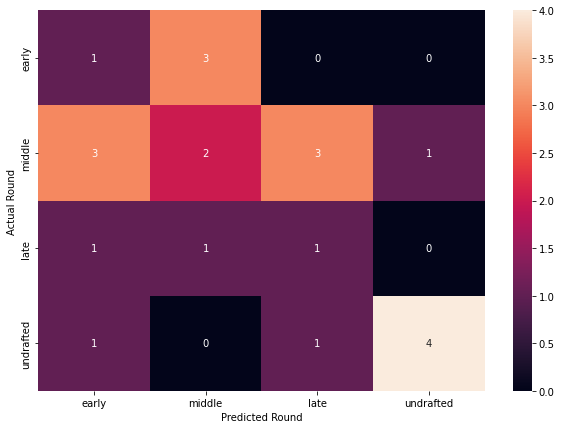

In [42]:
import seaborn as sn
import matplotlib.pyplot as plt
arr = confusion_matrix(test_labels, pred_labels,labels=['early', 'middle', 'late', 'undrafted'])

df_cm = pd.DataFrame(arr, index = ['early', 'middle', 'late', 'undrafted'],
                  columns = ['early', 'middle', 'late', 'undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")
plt.show()

In the above two cells, we use the testing set to create predicted labels based on the trained SVM model. We included a visual that represents the confusion matrix of the predictions. Looking at the accuracy value and the above visual, the SVM did not perform especially well. An accuracy of 0.36 indicates the the correctly predicted labels were almost certainly due to chance.

# Multinomial Logistic Regression

              precision    recall  f1-score   support

       early       0.50      0.25      0.33         4
        late       0.33      0.33      0.33         3
      middle       0.40      0.44      0.42         9
   undrafted       0.71      0.83      0.77         6

    accuracy                           0.50        22
   macro avg       0.49      0.47      0.46        22
weighted avg       0.49      0.50      0.49        22

accuracy: 0.5 was best at c =  0.1


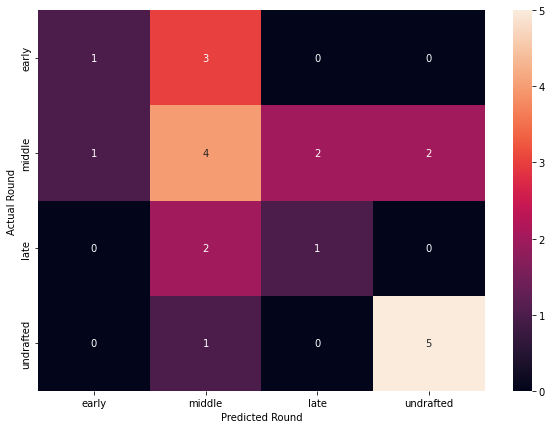

In [43]:
cs = [.1*i for i in range(1, 11)]
multinomialModel = None
most_correct = 0
best_c = 0
#create a multi-class logistic regression model, searches for the C-value that gives us the best model
for c in cs:
    multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=c)
    multinomialModel.fit(train_vectors, train_labels)
    pred_labels = multinomialModel.predict(test_vectors)

    num_correct = 0
    for i in range(len(pred_labels)):
        if pred_labels[i] == list(test_labels)[i]:
            num_correct += 1
            
    if num_correct > most_correct:
        best_c = c
        most_correct = num_correct
        
        
#creates the model with the best C-value found from above
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=best_c)

multinomialModel.fit(train_vectors, train_labels)

pred_labels = multinomialModel.predict(test_vectors)

print(classification_report(test_labels, pred_labels))

#predicts the labels of the testing set
num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1

print("accuracy:", num_correct/len(pred_labels), "was best at c = ", best_c)

import seaborn as sn

#create the visual based on the confusion matrix
arr = confusion_matrix(test_labels, pred_labels, labels=['early', 'middle', 'late', 'undrafted'])

df_cm = pd.DataFrame(arr, index = ['early', 'middle', 'late', 'undrafted'],
                  columns = ['early', 'middle', 'late', 'undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")
plt.show()

Finally, in the above two cells we use a type of logistic regression that uses multiple classes, also known as multinomial logistic regression. This model gave us a significantly higher accuracy value compared to the SVM. The accuracy value of 0.5 indicates that the correct predictions of the model are not solely due to chance. 

# Defensive Backs

### SVM

In [44]:
# Copy to prevent overwriting
db_labels = copy(db['round'])
# Here we make some alternate labels for SVM/multinomial logistic regression
db_labels_alt = db_labels
db_labels_alt[db_labels_alt == 1] = 'early'
db_labels_alt[db_labels_alt == 2] = 'early'
db_labels_alt[db_labels_alt == 3] = 'middle'
db_labels_alt[db_labels_alt == 4] = 'middle'
db_labels_alt[db_labels_alt == 5] = 'middle'
db_labels_alt[db_labels_alt == 6] = 'late'
db_labels_alt[db_labels_alt == 7] = 'late'
db_labels_alt[db_labels_alt == 8] = 'undrafted'


The cell above creates categorical labels we will use for predictions. Players were either drafted in the early rounds, middle rounds, late rounds, or were undrafted.

In [45]:
# Test/train split with default size, random_state 9
train_vectors, test_vectors, train_labels, test_labels = train_test_split(db_pca_features, db_labels_alt, random_state=9)

In [46]:
# Here we use GridSearch to find the best parameters

start = time.time()
print("Fitting the classifier to the training set")
# Creating our set of parameters to test
param_grid = {'C': [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
              'gamma': [0.0005, 0.001, 0.005, 0.01]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
# Fitting using our best estimator
clf = clf.fit(train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

end = time.time()
print("Runtime",end - start)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10.0, class_weight='balanced', gamma=0.005)
Runtime 0.19817519187927246


In [47]:
# Creating predicted labels to test the model
pred_labels = clf.predict(test_vectors)

print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels, labels=db_labels_alt.unique()))

num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1
        
# Print simple accuracy score
print("accuracy:", num_correct/len(pred_labels))

              precision    recall  f1-score   support

       early       0.54      0.64      0.58        11
        late       0.29      0.29      0.29         7
      middle       0.40      0.33      0.36        12
   undrafted       0.40      0.40      0.40        10

    accuracy                           0.42        40
   macro avg       0.41      0.41      0.41        40
weighted avg       0.42      0.42      0.42        40

[[7 3 0 1]
 [4 4 2 2]
 [1 1 2 3]
 [1 2 3 4]]
accuracy: 0.425


Text(69.0, 0.5, 'Actual Round')

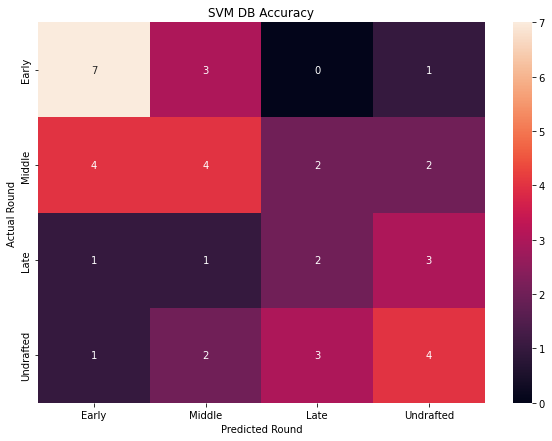

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt
# Making an array from a confusion matrix for plotting in seaborn
cm_arr = confusion_matrix(test_labels, pred_labels,labels=['early', 'middle', 'late', 'undrafted'])

cm_df = pd.DataFrame(cm_arr, index = ['Early', 'Middle', 'Late', 'Undrafted'],
                  columns = ['Early', 'Middle', 'Late', 'Undrafted'])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, annot=True)
plt.title('SVM DB Accuracy')
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

Overall, the SVM wasn't very good at predicting for DB's at an accuracy of 42.5%. As with the receivers, the model did perform fairly well at predicting early round guys in comparison to the other categories. GridSearch found that the best parameters were a C value of 10 and a gamma of 0.005.

# Multinomial

              precision    recall  f1-score   support

       early       0.71      0.45      0.56        11
        late       0.33      0.14      0.20         7
      middle       0.40      0.50      0.44        12
   undrafted       0.47      0.70      0.56        10

    accuracy                           0.48        40
   macro avg       0.48      0.45      0.44        40
weighted avg       0.49      0.47      0.46        40

accuracy: 0.475 at C =  0.4


Text(69.0, 0.5, 'Actual Round')

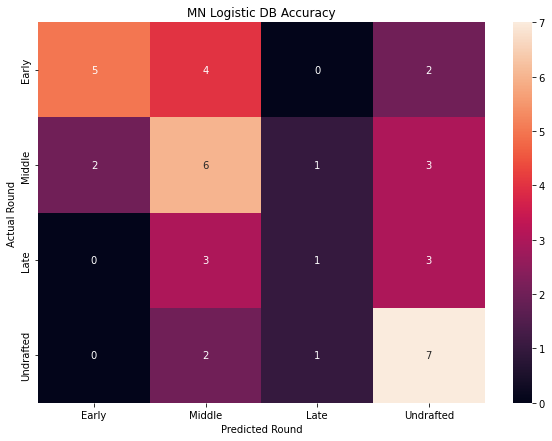

In [49]:
cs = [.1*i for i in range(1, 11)]
multinomialModel = None
most_correct = 0
best_c = 0
for c in cs: # loop through multiple C's to try them all
    multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=c)
    multinomialModel.fit(train_vectors, train_labels)
    pred_labels = multinomialModel.predict(test_vectors)

    num_correct = 0
    for i in range(len(pred_labels)):
        if pred_labels[i] == list(test_labels)[i]:
            num_correct += 1
            
    if num_correct > most_correct:
        best_c = c
        most_correct = num_correct
        
        
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=best_c)

multinomialModel.fit(train_vectors, train_labels)

pred_labels = multinomialModel.predict(test_vectors)

print(classification_report(test_labels, pred_labels))


num_correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == list(test_labels)[i]:
        num_correct += 1

print("accuracy:", num_correct/len(pred_labels), "at C = ", best_c)

import seaborn as sn
import matplotlib.pyplot as plt
cm_arr = confusion_matrix(test_labels, pred_labels, labels=['early', 'middle', 'late', 'undrafted'])

cm_df = pd.DataFrame(cm_arr, index = ['Early', 'Middle', 'Late', 'Undrafted'],
                  columns = ['Early', 'Middle', 'Late', 'Undrafted'])

plt.figure(figsize = (10,7))
sn.heatmap(cm_df, annot=True)
plt.title('MN Logistic DB Accuracy')
plt.xlabel('Predicted Round')
plt.ylabel("Actual Round")

The multinomial model performed slightly better than the SVM with an accuracy of 47.5%. It was best at identifying middle round picks and undrafted players. Using a C value of .4 resulted in the highest accuracy.

# Multiple Regression

### Regression Based on Overall Pick with All Features

In [50]:
# Regular multiple regression
x = sm.add_constant(db_features)
db_lm_overall = sm.OLS(db['overall'], x).fit()
db_lm_overall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     2.720
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           1.39e-05
Time:                        22:20:41   Log-Likelihood:                -902.17
No. Observations:                 160   AIC:                             1888.
Df Residuals:                     118   BIC:                             2017.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            -927.6515    556.030     -1.668      0.098   -2028.743     173.440
Height (in)                        -2.8831      4.620     -0.624      0.534     -12.033       6.267
Weight (lbs)                       -1.3478      0.899     -1.500      0.136      -3.127       0.432
40 Yard                           325.8887     84.127      3.874      0.000     159.293     492.484
Vert Leap (in)                      0.4165      2.962      0.141      0.888      -5.448       6.281
Broad Jump (in)                    -0.5888      0.702     -0.838      0.404      -1.980       0.802
Shuttle                           115.7893     77.854      1.487      0.140     -38.382     269.961
3Cone                             -41.3990     52.707     -0.785      0.434    -145.772      62.974
Total Total Tackles                 0.6926      0.412      1.680      0.096      -0.124       1.509
Mean Total Tackles                 -1.3030      2.154     -0.605      0.546      -5.569       2.963
Highest Total Tackles               0.4104      2.868      0.143      0.886      -5.269       6.090
Lowest Total Tackles               -1.1297      5.028     -0.225      0.823     -11.087       8.828
Total Solo Tackles                 -1.6184      1.385     -1.168      0.245      -4.361       1.125
Mean Solo Tackles                   8.0308      5.981      1.343      0.182      -3.813      19.875
Highest Solo Tackles               -2.2390      3.400     -0.659      0.511      -8.972       4.494
Lowest Solo Tackles                -0.0373      5.282     -0.007      0.994     -10.496      10.422
Total Assist Tackles                2.3110      1.660      1.392      0.166      -0.976       5.598
Mean Assist Tackles                -9.3339      7.268     -1.284      0.202     -23.726       5.058
Highest Assist Tackles              0.2972      4.215      0.071      0.944      -8.050       8.644
Lowest Assist Tackles              -0.2319      7.089     -0.033      0.974     -14.269      13.806
Total Passes Defended               4.5292      3.372      1.343      0.182      -2.148      11.206
Mean Passes Defended              -36.4645     14.621     -2.494      0.014     -65.417      -7.512
Highest Passes Defended             6.2748      4.476      1.402      0.164      -2.589      15.139
Lowest Passes Defended             16.6203      6.264      2.653      0.009       4.216      29.025
Total Sacks                         9.5940     29.047      0.330      0.742     -47.927      67.116
Mean Sacks                       -131.2702    102.778     -1.277      0.204    -334.799      72.259
Highest Sacks                      37.0274     26.511      1.397      0.165     -15.472      89.527
Lowest Sacks                       29.7882     61.440      0.485      0.629     -91

The model is ok with a R-squared of 48.6%. Most of the coefficients are insignificant, but due to the amount of variables and strong multicollinearity, interpreting the coefficients would not be advised, although we could attempt to use this model for prediction purposes.

### Regression based on Overall with PCA features

In [51]:
# regression with pca overall
x = sm.add_constant(db_pca_features)
db_pca_lm = sm.OLS(db['overall'], x).fit()
db_pca_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     3.642
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           2.25e-05
Time:                        22:20:41   Log-Likelihood:                -929.66
No. Observations:                 160   AIC:                             1891.
Df Residuals:                     144   BIC:                             1941.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.3812      6.730     23.387      0.000     144.080     170.683
x1            -1.0981      2.071     -0.530      0.597      -5.191       2.995
x2            -1.8939      2.631     -0.720      0.473      -7.094       3.306
x3           -13.2906      3.526     -3.769      0.000     -20.261      -6.321
x4            -5.4630      3.794     -1.440      0.152     -12.963       2.037
x5             6.2336      4.190      1.488      0.139      -2.048      14.515
x6            10.9298      4.226      2.587      0.011       2.578      19.282
x7            11.5569      5.040      2.293      0.023       1.595      21.519
x8            -5.1068      5.460     -0.935      0.351     -15.898       5.684
x9           -16.6709      5.768     -2.890      0.004     -28.073      -5.269
x10           -3.3067      6.176     -0.535      0.593     -15.514       8.901
x11           21.5910      6.395      3.376      0.001       8.950      34.232
x12           -3.6891      7.258     -0.508      0.612     -18.036      10.658
x13            4.5915      7.459      0.616      0.539     -10.153      19.336
x14           -3.6964      8.259     -0.448      0.655     -20.021      12.628
x15          -10.8199      8.433     -1.283      0.202     -27.488       5.848
==============================================================================
Omnibus:                        8.887   Durbin-Watson:                   0.757
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                3.987
Skew:                           0.075   Prob(JB):                        0.136
Kurtosis:                       2.241   Cond. No.                         4.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The PCA regression should remove much of the multicollinearity that plagued the previous model, although the model itself has a samller R squared and probably shouldn't be used for prediction purposes. This model also does not give us any information on what features are important.

### Get Importance of Features out of PCA

In [52]:
orig_coeff = np.matmul(db_pca.components_.transpose(), np.reshape(np.array(db_pca_lm.params[1:]), (np.array(db_pca_lm.params[1:]).shape[0], 1)))
# normalize to see what is important
norm_coeff = orig_coeff * np.reshape(np.array(db_features.std()), (np.array(db_features.std()).shape[0],1))
# I would not read too much into the exact coefficients or their sign, but largest magnitudes are most important
# Should be in the same order as features were
coeff = []
for i in range(len(norm_coeff)):
    coeff.append((norm_coeff[i], db_features.columns[i]))
importance = sorted(coeff, key = lambda x: abs(x[0]), reverse = True)
importance

[(array([237.66900715]), 'Total Total Tackles'),
 (array([188.65696271]), 'Total Solo Tackles'),
 (array([175.78511856]), 'Total Interception Yards'),
 (array([-130.36406388]), 'Broad Jump\xa0(in)'),
 (array([-125.3928852]), 'Weight\xa0(lbs)'),
 (array([62.16667208]), 'Lowest Interception Yards'),
 (array([49.01204444]), 'Total Assist Tackles'),
 (array([46.16030008]), 'Highest Interception Yards'),
 (array([-43.49702739]), 'Vert Leap\xa0(in)'),
 (array([42.52454437]), 'Mean Interception Yards'),
 (array([-32.82116856]), 'Lowest Total Tackles'),
 (array([-30.68363693]), 'Total Passes Defended'),
 (array([-29.36947698]), 'Highest Passes Defended'),
 (array([-27.60642083]), 'Height\xa0(in)'),
 (array([-26.24704361]), 'Highest Total Tackles'),
 (array([-25.82416343]), 'Lowest Solo Tackles'),
 (array([-20.77275254]), 'Highest Assist Tackles'),
 (array([-20.00097141]), 'Mean Total Tackles'),
 (array([-17.48808797]), 'Mean Passes Defended'),
 (array([-13.22335844]), 'Highest Interceptions'),

(-0.5, 999.5, 499.5, -0.5)

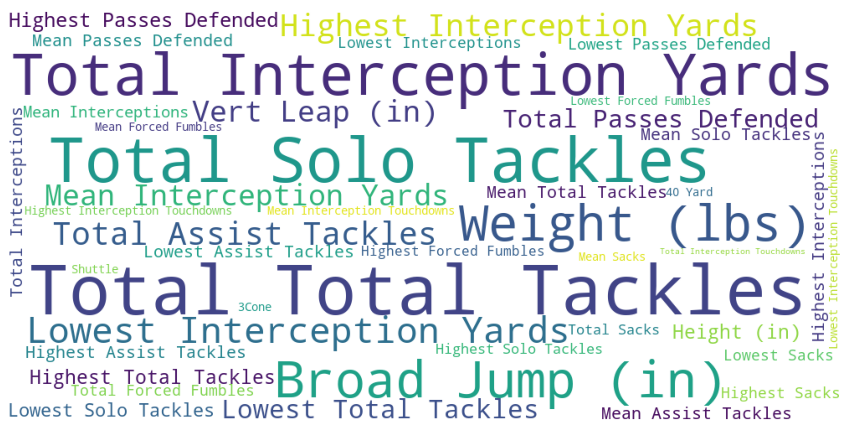

In [53]:
counter = dict()
for att in importance:
    counter[att[1]] = max(10, abs(int(att[0][0]))//2) # make the less used features easier to read
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

# Conclusion

Overall, our classifier accuracy was very low especially on the groups with low sample size like quarterbacks. It ranged from about 30% to 52% across the different position groups and classifiers. The Multinomial logistic models that we used tended to be slightly better on average. These were particularly successful at identifying the early round and undrafted classes. Our models tended to perform poorly when we attempted to use too many classes such as overall pick, round, etc. We can conclude that raw statistics may not tell the whole picture when it comes to drafting. Because of playstyle and competition differences, players with similar stats may not have equal skill levels or potential.

If we were to continue this project or something similar, we might use something like TensorFlow or another type of Machine Learning that can perhaps get a higher accuracy. We could also look into how position affects draft position/order or whether there are other attributes that can help to predict besides raw stats. Another possible avenue could be to normalize the statistics relative to their teams playstyle.

The linear regression models were ok, with an adjusted R squared between .2 and .5 for most of the positions, which is not something that we would want to be making too many predictions with. Using the PCA features did a better job for quaterback and runningback, but was generally in the same range. Most importantly, the PCA reduced multicollinearity which would make interpreting the original coefficients pointless. But, we are able to use the PCA and perform a change of basis to see what features are the most important. Overall, it appears that playing statistics were the most important in these regressions, where the combine statistics were generally not as important.